Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [7]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import scipy.stats as st 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [9]:
df = pd.read_csv('ab_statistic.csv')

In [10]:
df.describe(include='all')

,USER_ID,VARIANT_NAME,REVENUE
count,10000.000000,10000,10000.000000
unique,NaN,2,NaN
top,NaN,variant,NaN
freq,NaN,5016,NaN
mean,4981.080200,NaN,0.099447
std,2890.590115,NaN,2.318529
min,2.000000,NaN,0.000000
25%,2468.750000,NaN,0.000000
50%,4962.000000,NaN,0.000000
75%,7511.500000,NaN,0.000000


In [11]:
# Очистка данных
# Заменить 'variant' на 'A', 'control' на 'B', удалить все остальные значения
df['VARIANT_NAME'] = np.where(df['VARIANT_NAME'] == 'variant', 'A', df['VARIANT_NAME'])
df['VARIANT_NAME'] = np.where(df['VARIANT_NAME'] == 'control', 'B', df['VARIANT_NAME'])

# Удалить строки, не содержащие 'A' или 'B' в 'VARIANT_NAME'
df = df[df['VARIANT_NAME'].isin(['A', 'B'])]

In [12]:
# Удалить дубликаты по 'USER_ID'
df.drop_duplicates(subset='USER_ID', inplace=True)

In [13]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,A,0.0
1,2423,B,0.0
2,9411,B,0.0
3,7311,B,0.0
4,6174,A,0.0


In [14]:
df = pd.read_csv('ab_statistic.csv')
# Убедимся, что нет лишних пробелов в названиях столбцов
df.columns = df.columns.str.strip()
# Проверим наличие пропущенных значений в данных
missing_values = df.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values)

Пропущенные значения в данных:
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64


In [15]:
# Удалим строки с пропущенными значениями в 'REVENUE'
df_cleaned = df.dropna(subset=['REVENUE'])
# Подсчет количества положительных значений дохода
count_positive_revenue = (df_cleaned['REVENUE'] > 0).sum()
print("Количество строк с положительным доходом:", count_positive_revenue)

Количество строк с положительным доходом: 152


In [42]:
# Вывод уникальных значений в столбце 'REVENUE' с двумя десятичными знаками
unique_revenue_values = df_cleaned['REVENUE'].apply(lambda x: f'{x:.2f}').unique()
print("Уникальные значения в столбце 'REVENUE':")
print(unique_revenue_values)


Уникальные значения в столбце 'REVENUE':
['0.00' '2.15' '3.25' '4.27' '1.75' '2.99' '9.91' '1.26' '10.63' '17.05'
 '2.17' '1.25' '5.45' '4.87' '3.75' '17.87' '196.01' '11.98' '0.50' '1.56'
 '1.51' '3.99' '1.50' '3.98' '1.36' '3.24' '0.04' '23.04' '2.01' '1.00'
 '8.70' '10.82' '4.95' '1.01' '2.72' '0.02' '0.58' '2.00' '17.08' '2.27'
 '2.14' '8.66' '2.19' '14.24' '1.52' '0.86' '1.77' '0.60' '2.02' '2.70'
 '5.08' '4.33' '12.99' '2.16' '3.28' '3.97' '1.29' '5.02' '19.47' '18.56'
 '2.50' '3.00' '6.46' '3.83' '2.22' '3.79' '20.07' '58.63' '4.52' '9.99'
 '2.34' '2.95' '3.58' '0.84' '1.92' '10.67' '7.27' '7.58' '2.60' '0.90'
 '57.46' '6.35' '4.98' '29.32' '1.30' '5.98' '0.06' '1.99' '2.52' '1.23'
 '14.07' '25.98' '2.24' '4.37' '1.66' '41.53' '1.78' '0.23' '2.93' '14.17'
 '2.92']


In [17]:
# Выведем только ненулевые значения 'REVENUE' для каждого 'VARIANT_NAME'
non_zero_revenue = df_cleaned[df_cleaned['REVENUE'] > 0][['VARIANT_NAME', 'REVENUE']]
print(non_zero_revenue)

# Подсчитаем суммы доходов для каждого варианта
sum_by_variant = non_zero_revenue.groupby('VARIANT_NAME')['REVENUE'].sum()
print("\nСуммы доходов для каждого варианта:")
print(sum_by_variant)


     VARIANT_NAME  REVENUE
13        variant     2.15
49        control     3.25
139       variant     4.27
149       variant     1.75
152       control     2.99
...           ...      ...
9651      variant     1.25
9711      control     2.93
9724      control    14.17
9725      variant     2.92
9977      variant     1.01

[152 rows x 2 columns]

Суммы доходов для каждого варианта:
VARIANT_NAME
control    643.00
variant    351.47
Name: REVENUE, dtype: float64


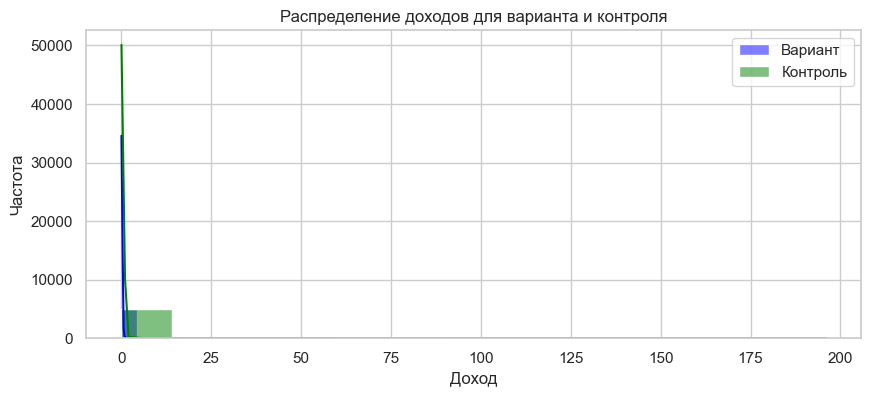

In [37]:
data_variant = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
data_control = df[df['VARIANT_NAME'] == 'control']['REVENUE']

# гистограмма
plt.figure(figsize=(10, 4))
sns.histplot(data_variant, kde=True, color='blue', label='Вариант')
sns.histplot(data_control, kde=True, color='green', label='Контроль')

plt.title('Распределение доходов для варианта и контроля')
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.legend()
plt.show()

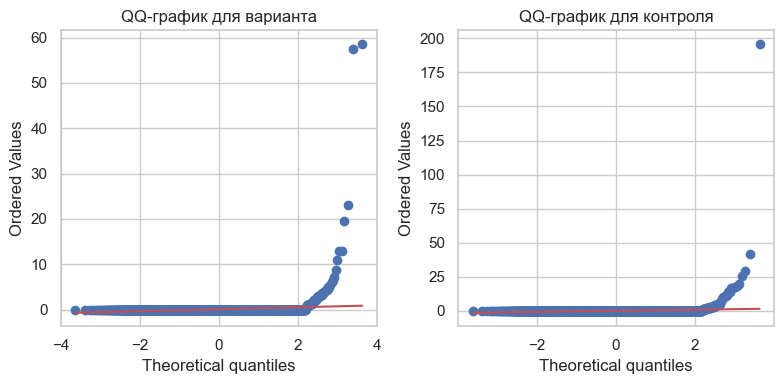

In [35]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
data_variant = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
data_control = df[df['VARIANT_NAME'] == 'control']['REVENUE']

# QQ-график
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
probplot(data_variant, plot=plt)
plt.title('QQ-график для варианта')

plt.subplot(1, 2, 2)
probplot(data_control, plot=plt)
plt.title('QQ-график для контроля')

plt.tight_layout()
plt.show()


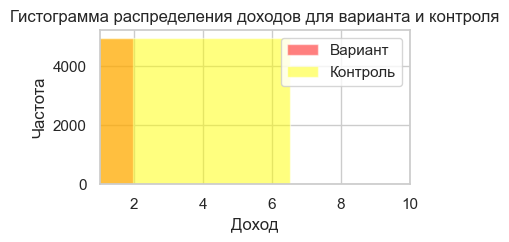

In [32]:
# Создадим подвыборки для A и B
data_variant = df_cleaned[df_cleaned['VARIANT_NAME'] == 'variant']['REVENUE']
data_control = df_cleaned[df_cleaned['VARIANT_NAME'] == 'control']['REVENUE']

# Гистограмма
plt.figure(figsize=(4, 2))
plt.hist(data_variant, bins=30, alpha=0.5, label='Вариант', color='red')
plt.hist(data_control, bins=30, alpha=0.5, label='Контроль', color='yellow')
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.legend()
plt.xlim(1, 10)  # Установим пределы оси X от 1 до 10
plt.title('Гистограмма распределения доходов для варианта и контроля')
plt.show()




In [30]:
# Проведем тест Шапиро-Уилка
stat_variant, p_value_variant = shapiro(data_variant)
stat_control, p_value_control = shapiro(data_control)

print(f'Shapiro-Уилк тест для варианта: W = {stat_variant}, p-value = {p_value_variant}')
print(f'Shapiro-Уилк тест для контроля: W = {stat_control}, p-value = {p_value_control}')

Shapiro-Уилк тест для варианта: W = 0.027033090591430664, p-value = 0.0
Shapiro-Уилк тест для контроля: W = 0.018331527709960938, p-value = 0.0


c:\Users\akopeikina\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


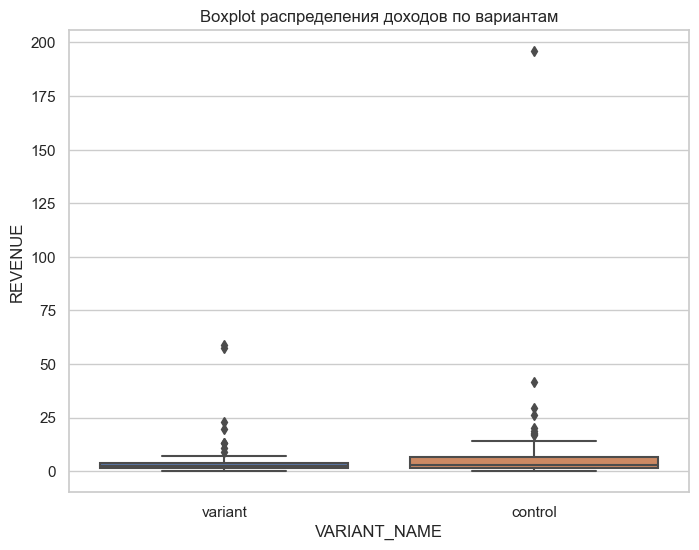

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Установим стиль графика
sns.set(style="whitegrid")

# Создадим ящик с усами
plt.figure(figsize=(8, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df[df['REVENUE'] > 0])

# Добавим название графика
plt.title('Boxplot распределения доходов по вариантам')

# Покажем график
plt.show()


In [44]:
from scipy.stats import shapiro
# Тест Шапиро-Уилка для варианта
stat_var, p_var = shapiro(df_cleaned[df_cleaned['VARIANT_NAME'] == 'variant']['REVENUE'])
print(f"Shapiro-Уилк тест для варианта: W = {stat_var:.3f}, p-value = {p_var:.6f}")

# Тест Шапиро-Уилка для контроля
stat_ctrl, p_ctrl = shapiro(df_cleaned[df_cleaned['VARIANT_NAME'] == 'control']['REVENUE'])
print(f"Shapiro-Уилк тест для контроля: W = {stat_ctrl:.3f}, p-value = {p_ctrl:.6f}")


Shapiro-Уилк тест для варианта: W = 0.027, p-value = 0.000000
Shapiro-Уилк тест для контроля: W = 0.018, p-value = 0.000000


c:\Users\akopeikina\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результаты теста Шапиро-Уилка указывают на то, что данные в обеих группах (вариант и контроль) не подчиняются нормальному распределению, так как p-value стремится к нулю. Таким образом, использование t-теста может быть неправильным, поскольку он предполагает нормальное распределение данных.

In [50]:
# Можно рассмотреть использование непараметрического теста U-тест Манна-Уитни,
# который не требует предположения о нормальности данных.
from scipy.stats import mannwhitneyu
# Выберем только положительные значения дохода
df_positive_revenue = df[df['REVENUE'] > 0]
# Разделим данные на две группы: вариант (variant) и контроль (control)
revenue_variant = df_positive_revenue[df_positive_revenue['VARIANT_NAME'] == 'variant']['REVENUE']
revenue_control = df_positive_revenue[df_positive_revenue['VARIANT_NAME'] == 'control']['REVENUE']

# Проведем U-тест Манна-Уитни для сравнения двух групп
u_statistic, p_value_mannwhitney = mannwhitneyu(revenue_variant, revenue_control)
# Выведем результаты U-теста Манна-Уитни
print(f"U-статистика (Манна-Уитни): {u_statistic:.3f}")
print(f"p-value (Манна-Уитни): {p_value_mannwhitney:.6f}")

# Проверим статистическую значимость
alpha = 0.05
if p_value_mannwhitney < alpha:
    print("Результат статистически значим, отклоняем нулевую гипотезу.")
else:
    print("Нет статистической значимости, нулевая гипотеза не отклоняется.")

U-статистика (Манна-Уитни): 2404.000
p-value (Манна-Уитни): 0.079243
Нет статистической значимости, нулевая гипотеза не отклоняется.


Напутствие команде:

Продолжайте анализировать данные и проверять их корректность.

Результаты теста показывают, что распределение доходов в обеих группах статистически значимо отличается от нормального. Это также подтверждается гистограммой и наличием тяжелых хвостов в распределении.
Проверьте и почистите данные от выбросов или ошибок.

Проведите более глубокий статистический анализ, возможно, используя другие тесты на нормальность.
Рассмотрите использование альтернативных методов анализа, если данные не соответствуют предполагаемым распределениям.

Ваши данные не позволяют отклонить нулевую гипотезу на уровне значимости 0.05.

Подумайте о дополнительных исследованиях или анализе данных, чтобы лучше понять различия между вашими группами.

Помните, что отсутствие статистической значимости не означает отсутствие различий; это может быть вызвано недостаточным размером выборки или другими факторами.

Проверьте, были ли какие-либо проблемы с данными или проведите чувствительность анализа к возможным изменениям.